In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns

In [18]:
transform=transforms.Compose(
    [transforms.Resize((50,50)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))]
)

In [19]:
batch_size = 4
trainset = torchvision.datasets.ImageFolder(root='dataset/multiclass/data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='dataset/multiclass/data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
CLASSES=['affenpinscher', 'akita','corgi']

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

get some random training images

In [ ]:
# dataiter = iter(trainloader)
# images, labels = dataiter.__next__()
# imshow(torchvision.utils.make_grid(images, nrow=2))

Neural Network setup

In [26]:
NUM_CLASSES = len(CLASSES)
class ImageClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.fc1=nn.Linear(in_features=16 * 11 * 11, out_features=128)
        self.fc2=nn.Linear(in_features=128, out_features=64)
        self.fc3=nn.Linear(in_features=64, out_features=NUM_CLASSES)
        self.relu=nn.ReLU()
        self.softmax = nn.LogSoftmax()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x) # out: (BS, 6, 48, 48)
        x = self.relu(x)
        x = self.pool(x) # out: (BS, 6, 24, 24)
        x = self.conv2(x) # out: (BS, 16, 22, 22)
        x = self.relu(x)
        x = self.pool(x) # out: (BS, 16, 11, 11)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
        
        

init model

In [27]:
# input = torch.rand(1, 1, 50, 50) # BS, C, H, W
model = ImageClassificationNet() 
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Training

In [31]:
losses=[]
Num_Epochs=100
for epoch in range(Num_Epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, labels.shape,labels,outputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{Num_Epochs}, Step {i+1}/{len(trainloader)}, Loss: {loss.item():.4f}')
        

c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 0/100, Step 75/75, Loss: 0.7096
Epoch 10/100, Step 75/75, Loss: 0.0000
Epoch 20/100, Step 75/75, Loss: 0.0000
Epoch 30/100, Step 75/75, Loss: 0.0000
Epoch 40/100, Step 75/75, Loss: 0.0000
Epoch 50/100, Step 75/75, Loss: 0.0000
Epoch 60/100, Step 75/75, Loss: 0.0000
Epoch 70/100, Step 75/75, Loss: 0.0000
Epoch 80/100, Step 75/75, Loss: 0.0000
Epoch 90/100, Step 75/75, Loss: 0.0000


Evaluation

<Axes: >

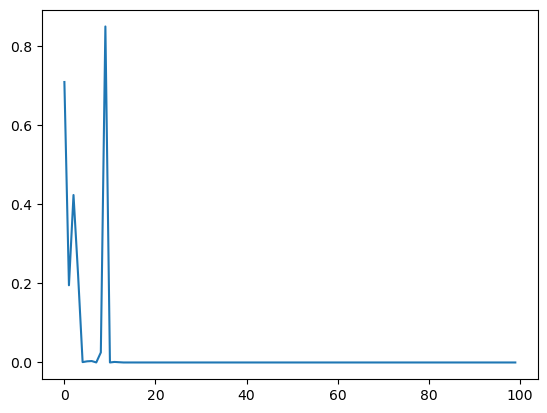

In [32]:
sns.lineplot(x=range(len(losses)), y=losses)

test

In [33]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [37]:
acc = accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 88.33 %


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Convert probabilities to predicted labels for multi-class classification
y_pred = np.argmax(y_test_hat, axis=1)

# Precision, Recall, and F1-score for multi-class classification
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Precision: 89.78%
Recall: 88.33%
F1-Score: 88.15%


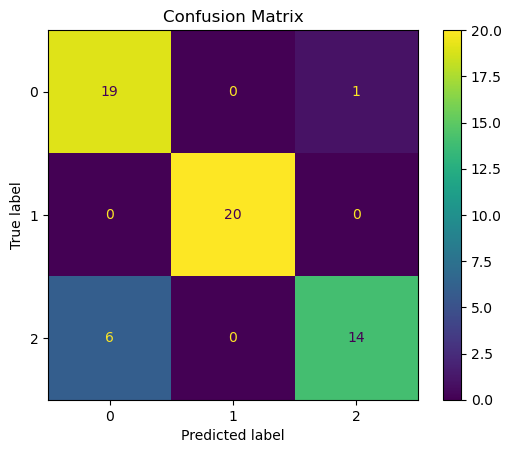

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# y_test_hat_list=[y_hat.item() for i,y_hat in enumerate(y_test_hat)]
# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix')
plt.show()

Model Save

In [42]:
torch.save(model.state_dict(), 'artifacts/cnn_multi_classification.pth')

In [44]:
model_loaded = ImageClassificationNet()
model_loaded.load_state_dict(torch.load('artifacts/cnn_multi_classification.pth'))
model_loaded.eval()

ImageClassificationNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=None)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [45]:
from PIL import Image
# Load and preprocess the image
img_path = 'dataset/multiclass/data/test/affenpinscher/affenpinscher_12.jpg'
img = Image.open(img_path)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

In [51]:

with torch.no_grad():
    result = model_loaded(img_tensor).round()
    pred=torch.argmax(result).item()

    # Print the predicted class
    print(f"Predicted class: {CLASSES[pred]}")

    

Predicted class: affenpinscher


c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
